In [1]:
import pyclesperanto_prototype as cle
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

We're using a dataset published by [Heriche et al.](https://doi.org/10.1091/mbc.E13-04-0221) licensed [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) available in the [Image Data Resource](https://idr.openmicroscopy.org/webclient/img_detail/179719/).

cl.OCLArray([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
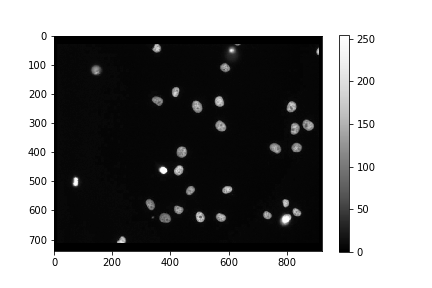
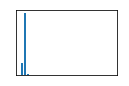

In [14]:
# load file
raw_image = imread('../../data/plate1_1_013 [Well 5, Field 1 (Spot 5)].png')[::2,::2,0]

# visualize
cle.asarray(raw_image)

## Starting point: a label image
For demonstration purposes, we need a label image with labeled nuclei.

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
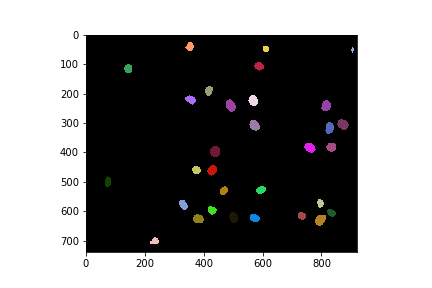

In [3]:
labels = cle.voronoi_otsu_labeling(raw_image, spot_sigma=7)
labels

## Measurements
Now, we count the number of neighbors around each nucleus in a certain radius.

In [4]:
statistics = cle.statistics_of_labelled_neighbors(labels)
number_of_neighbors = statistics["proximal_neighbor_count_d160"].tolist()
print(number_of_neighbors)

[0.0, 0.0, 1.0, 6.0, 0.0, 2.0, 5.0, 4.0, 3.0, 5.0, 7.0, 3.0, 9.0, 4.0, 5.0, 4.0, 2.0, 5.0, 2.0, 3.0, 1.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, 4.0, 3.0, 4.0, 0.0]


c:\structure\code\pyclesperanto_prototype\pyclesperanto_prototype\_tier9\_statistics_of_labelled_neighbors.py:69: RuntimeWarning: invalid value encountered in divide
  all_stats["max_min_distance_ratio_of_touching_neighbors"] = all_stats["maximum_distance_of_touching_neighbors"] / all_stats["minimum_distance_of_touching_neighbors"]


## Visualizing measurements as map
Our goal is now to visualize those measurements as a _quantitative parameter image_. Sometimes these images are also referred to as _feature images_ or _feature maps_.

### The naive way
The most straight forward way to do this is using a for-loop iterating over pixels and replacing e.g. label `1` with the measurement corresponding to label `1`. While this is a reasonable strategy, it may also be the one with the longest code and the slowest way of doing it:

C:\Users\rober\miniconda3\envs\bio_39\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


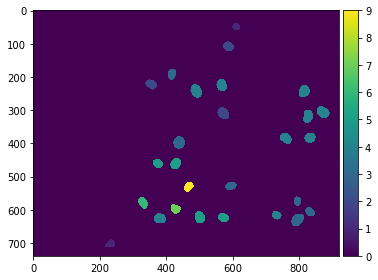

In [5]:
neighbor_count_map_naive = np.zeros(labels.shape)

for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        label = labels[y, x]
        # we subtract 1 from the label to retrieve the
        # index of the measurement in the array because 
        # there is no measurement for background
        measurement = number_of_neighbors[label - 1]
        neighbor_count_map_naive[y, x] = measurement 

imshow(neighbor_count_map_naive)

## The state-of-the-art way
A much shorter way for doing this, which is also much faster is using [numpy](https://numpy.org). As numpy is likely the most commonly used Python library, we can consider such a solution the state-of-the-art.

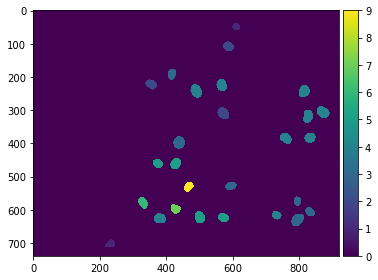

In [12]:
# The prefixed [0] represents the measurement for the background
neighbor_count_map_numpy = np.take([0] + number_of_neighbors, labels)

imshow(neighbor_count_map_numpy)

### The clesperanto-way
In the [clesperanto project](https://clesperanto.net) we spent time to design the function names and parameters in a way so that they are  self-explanatory and easy to understand. Those function names are typically a bit longer but make the code easier to read.

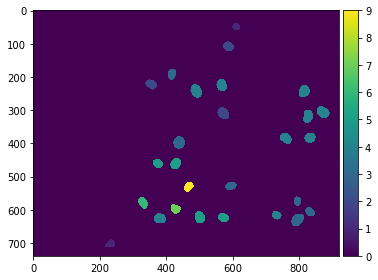

In [13]:
# The prefixed [0] represents the measurement for the background
neighbor_count_map_cle = cle.replace_intensities(labels, [0] + number_of_neighbors)

imshow(neighbor_count_map_cle)

## Validation
Whenever using functions that are supposed to do the same, please be a good scientist and spend some time to check if this assumption is actually true.

In [8]:
np.array_equal(neighbor_count_map_naive, neighbor_count_map_numpy)

True

In [9]:
np.array_equal(neighbor_count_map_naive, neighbor_count_map_cle)

True

If the above two were true, the next one must be as well.

In [10]:
np.array_equal(neighbor_count_map_numpy, neighbor_count_map_cle)

True

## Exercise
Use [scikit-image's regionprops](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html) to measure the major axis length of the labeled nuclei and visualize the measurement in a `major_axis_length_map`.